In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow

In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b

    return gray

def blend_images(orig, four):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = 10, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, 0.8)
    return new_img


class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - int(1/step))
        self.y_batches = int(picture.shape[0] // (batch_size * step) - int(1/step))
        self.picture = copy.deepcopy(picture)
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
#                 yield Cepstrum.calculate_cepstrum(self.picture[y * pixel_step : y * pixel_step + self.batch_size,
#                                    x * pixel_step : x * pixel_step + self.batch_size ])
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size ]))
#                 yield self.picture[y * pixel_step : y * pixel_step + self.batch_size,
#                                    x * pixel_step : x * pixel_step + self.batch_size ]

    def ft_array(self):
        temp_obj = np.ndarray((self.batch_size, self.batch_size), dtype='float')
        a = np.array(list(self.get_square()))
        self.output = a.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))

    def make_big_image(self, threshold=0.5):
        try:
            temp = [ 0 ] * self.y_batches
            for y in range(self.y_batches):
                temp[y] = np.hstack(self.output[y, :, :, :])
            self.big_image = np.vstack(temp)
#             return self.threshold_big_image()
            return self.big_image
        except AttributeError:
            print("!!! Use ft_array() function first !!!")
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d

    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
#         fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
#         fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        
#         fourier_abs *= (1.0/fourier_abs.max())
#         fourier_abs[fourier_abs < 0.1] = 0
        return fourier_abs
    
    def threshold_big_image(self, threshold=0.5):
        fourier_abs = self.big_image
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs < 0.1] = 0
        return self.big_image
    
    def swap_quarters(self, picture):
        batch_size = self.batch_size
        out_pict = copy.deepcopy(picture)
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict

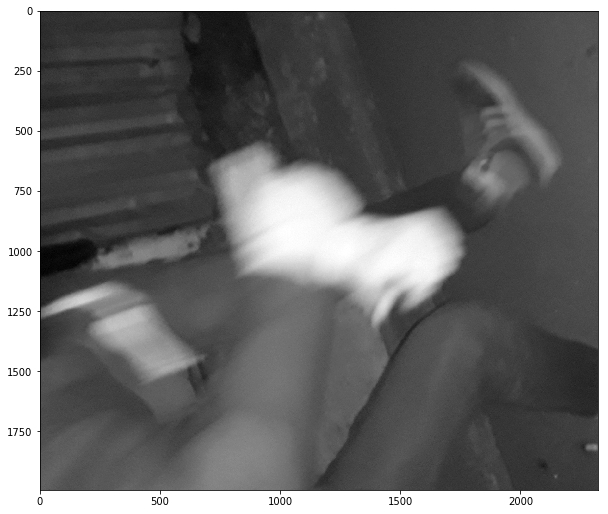

In [6]:
work_dir = "../pict/"
save_dir = "../res_26.11/"
# filename = "mb0.jpg"
# filename = "mb1.jpg"
filename = "ser.jpg"

img = rgb2gray(plt.imread(work_dir + filename))

#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')
#ax2.imshow(b)

In [13]:
c = Cepstrum(img, batch_size=512, step=0.25)
# c = Cepstrum(img)
c.ft_array()

q = c.make_big_image()
plt.imsave('big_img.png', q, cmap='gray')

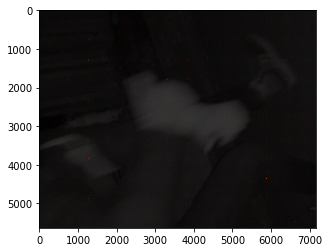

In [14]:
d = blend_images('orig_img.png', 'big_img.png')
imshow(np.asarray(d))
d.save(save_dir + filename[:-4] + "_" + str(c.batch_size) + '_' + str(c.step) + '_visualisation.png')

In [19]:
filenames = ['mb0.jpg', 'mb1.jpg']
b_sizes = [32, 64, 128]
steps = [0.25, 0.5]

# for filename in filenames:
filename = 'cm.PNG'
for batch_size in b_sizes:
    for step in steps:
        img = rgb2gray(plt.imread(work_dir + filename))
#         c = Cepstrum(img[2000:3500, 1000:2800], batch_size=batch_size, step=step)
        c = Cepstrum(img, batch_size=batch_size, step=step)
        c.ft_array()

        q = c.make_big_image()
        plt.imsave('big_img.png', q, cmap='gray')

        d = blend_images('orig_img.png', 'big_img.png')
        d.save(save_dir + filename[:-4] + "_" + str(c.batch_size) + '_' + str(c.step) + '_visualisation.png')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log
/home/lepossum/.local/lib/python3.6/site-packages/numpy/fft/fftpack.py:303: RuntimeWarning: invalid value encountered in multiply
  return output * (1 / (sqrt(n) if unitary else n))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater
